# 1. Installing required packages 

In [ ]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import yaml
from ultralytics import YOLO
#Last section contains instructions and summary for the project

# 2. Setting path to local dataset

In [16]:

dataset_root = r'C:\Users\dell\pid_env\pid_symbols_dataset'  #setting path to local dataset


# 3. Verify dataset structure

In [17]:
#
images_dir = os.path.join(dataset_root, 'images')
labels_dir = os.path.join(dataset_root, 'labels')
train_txt = os.path.join(dataset_root, 'train.txt')
val_txt = os.path.join(dataset_root, 'val.txt')

In [18]:
print(f"Checking dataset structure...")
print(f"Images directory exists: {os.path.exists(images_dir)}")
print(f"Labels directory exists: {os.path.exists(labels_dir)}")
print(f"train.txt exists: {os.path.exists(train_txt)}")
print(f"val.txt exists: {os.path.exists(val_txt)}")

Checking dataset structure...
Images directory exists: True
Labels directory exists: True
train.txt exists: True
val.txt exists: True


In [19]:
if not os.path.exists(train_txt) or not os.path.exists(val_txt):
    print("Warning: train.txt or val.txt files not found. Creating them...")
    
    # Create train/val split if files don't exist
    all_images = os.listdir(images_dir)
    from sklearn.model_selection import train_test_split
    
    train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)
    
    with open(train_txt, 'w') as f:
        for img in train_images:
            img_path = os.path.join(images_dir, img)
            f.write(f"{img_path}\n")
    
    with open(val_txt, 'w') as f:
        for img in val_images:
            img_path = os.path.join(images_dir, img)
            f.write(f"{img_path}\n")
    
    print(f"Created train.txt with {len(train_images)} images and val.txt with {len(val_images)} images.")


# 4. Creating YOLOv8 dataset structure

In [20]:
yolo_dataset = 'yolo_dataset'
os.makedirs(yolo_dataset, exist_ok=True)

In [21]:
yolo_images_train = os.path.join(yolo_dataset, 'images', 'train')
yolo_images_val = os.path.join(yolo_dataset, 'images', 'val')
yolo_labels_train = os.path.join(yolo_dataset, 'labels', 'train')
yolo_labels_val = os.path.join(yolo_dataset, 'labels', 'val')

for path in [yolo_images_train, yolo_images_val, yolo_labels_train, yolo_labels_val]:
    os.makedirs(path, exist_ok=True)

# 5. Function to organize dataset

In [22]:

def organize_dataset(txt_file, img_dest, label_dest):
    """
    Copies images and labels to YOLOv8 directory structure
    Args:
        txt_file: Path to train.txt or val.txt
        img_dest: Target images directory
        label_dest: Target labels directory
    """
    if not os.path.exists(txt_file):
        print(f"Warning: {txt_file} not found!")
        return
        
    with open(txt_file, 'r') as f:
        lines = f.read().splitlines()
        
    for line in lines:
        try:
            # Extract image name from path
            img_name = os.path.basename(line)
            
            # Handle case where paths in txt are relative or absolute
            if os.path.exists(line):
                img_src = line
            else:
                # Try to find the image in the images directory
                img_src = os.path.join(images_dir, img_name)
                
            if not os.path.exists(img_src):
                print(f"Image not found: {img_src}")
                continue
                
            # Copy image
            img_dst = os.path.join(img_dest, img_name)
            shutil.copy(img_src, img_dst)
            
            # Copy corresponding label
            label_name = img_name.rsplit('.', 1)[0] + '.txt'
            label_src = os.path.join(labels_dir, label_name)
            label_dst = os.path.join(label_dest, label_name)
            
            if os.path.exists(label_src):
                shutil.copy(label_src, label_dst)
            else:
                print(f"Missing label: {label_name}")
                
        except Exception as e:
            print(f"Error processing {line}: {str(e)}")




In [ ]:
# Process train and validation sets
print("Organizing dataset into YOLOv8 format...")
organize_dataset(train_txt, yolo_images_train, yolo_labels_train)
organize_dataset(val_txt, yolo_images_val, yolo_labels_val)

Organizing dataset into YOLOv8 format...


# 6. Verify the dataset organization

In [10]:

print("Training images:", len(os.listdir(yolo_images_train)))
print("Validation images:", len(os.listdir(yolo_images_val)))
print("Training labels:", len(os.listdir(yolo_labels_train)))
print("Validation labels:", len(os.listdir(yolo_labels_val)))

Training images: 27000
Validation images: 3000
Training labels: 27000
Validation labels: 3000


# 7. Determine actual classes from labels

In [ ]:

def get_classes_from_labels(labels_dir):
    """Extract unique class IDs from label files"""
    class_ids = set()
    
    for label_file in os.listdir(labels_dir):
        try:
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(float(parts[0]))
                        class_ids.add(class_id)
        except Exception as e:
            print(f"Error processing {label_file}: {str(e)}")
    
    return sorted(list(class_ids))

class_ids = get_classes_from_labels(yolo_labels_train)
print(f"Found {len(class_ids)} unique classes: {class_ids}")

nc : 32 
pid_classes = {
0: 'pipe_coupling',
1: 'check_valve',
2: 'gate_valve_vertical',
3: 'gate_valve_horizontal',
4: 'globe_valve',
5: 'three_way_valve',
6: 'needle_valve',
7: 'control_valve',
8: 'ball_valve',
9: 'butterfly_valve',
10: 'plug_valve',
11: 'quick_connect_coupling',
12: 'relief_valve',
13: 'pressure_reducing_valve',
14: 'rupture_disk',
15: 'float_trap',
16: 'line_size_marker',
17: 'line_specification_break',
18: 'temperature_indicator',
19: 'flow_indicator',
20: 'point_indicator',
21: 'equipment_tag_rectangular',
22: 'equipment_tag_circular',
23: 'equipment_tag_octagonal',
24: 'equipment_tag_hexagonal',
25: 'instrument_bubble_circular',
26: 'instrument_bubble_square',
27: 'junction_box',
28: 'heat_exchanger',
29: 'station_panel',
30: 'tank',
31: 'filter',
}


for class_id in class_ids:
    if class_id not in pid_classes:
        pid_classes[class_id] = f'class_{class_id}'


# 8. Create YAML configuration

In [12]:

yaml_content = {
    'path': os.path.abspath(yolo_dataset),
    'train': 'images/train',
    'val': 'images/val',
    'names': {str(k): v for k, v in pid_classes.items()}
}

with open('pid_config.yaml', 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print("Created YAML configuration with the following classes:")
for class_id, class_name in pid_classes.items():
    print(f"  {class_id}: {class_name}")


Created YAML configuration with the following classes:
  0: pipe_coupling
  1: check_valve
  2: gate_valve_vertical
  3: gate_valve_horizontal
  4: globe_valve
  5: three_way_valve
  6: needle_valve
  7: control_valve
  8: ball_valve
  9: butterfly_valve
  10: plug_valve
  11: quick_connect_coupling
  12: relief_valve
  13: pressure_reducing_valve
  14: rupture_disk
  15: float_trap
  16: line_size_marker
  17: line_specification_break
  18: temperature_indicator
  19: flow_indicator
  20: point_indicator
  21: equipment_tag_rectangular
  22: equipment_tag_circular
  23: equipment_tag_octagonal
  24: equipment_tag_hexagonal
  25: instrument_bubble_circular
  26: instrument_bubble_square
  27: junction_box
  28: heat_exchanger
  29: station_panel
  30: tank
  31: filter
  32: class_32


# 9. Visualize sample data with annotations

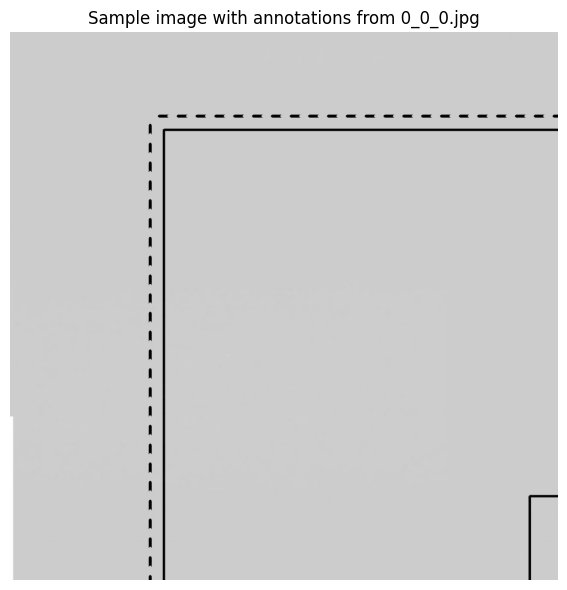

In [13]:

def plot_sample(image_path, label_path, class_names=None):
    """Displays image with bounding boxes"""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title("Image without annotations")
        plt.show()
        return
    
    with open(label_path, 'r') as f:
        annotations = f.readlines()
    
    h, w = image.shape[:2]
    
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    
    for ann in annotations:
        try:
            parts = ann.strip().split()
            if len(parts) >= 5:
                class_id = int(float(parts[0]))
                x_center, y_center, width, height = map(float, parts[1:5])
                
                x_center *= w
                y_center *= h
                width *= w
                height *= h
                
                x_min = int(x_center - width/2)
                y_min = int(y_center - height/2)
                x_max = int(x_center + width/2)
                y_max = int(y_center + height/2)
                
                rect = plt.Rectangle((x_min, y_min), width, height, 
                                   fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
                
                # Add class label
                class_name = class_names.get(class_id, f"class_{class_id}") if class_names else f"class_{class_id}"
                plt.text(x_min, y_min-5, class_name, 
                         color='white', fontsize=10, 
                         bbox=dict(facecolor='red', alpha=0.7))
        except Exception as e:
            print(f"Error processing annotation: {ann} - {str(e)}")
    
    plt.axis('off')
    plt.title(f"Sample image with annotations from {os.path.basename(image_path)}")
    plt.tight_layout()
    plt.show()

# Display first training sample
sample_images = os.listdir(yolo_images_train)
if sample_images:
    sample_image = sample_images[0]
    sample_image_path = os.path.join(yolo_images_train, sample_image)
    sample_label_path = os.path.join(yolo_labels_train, sample_image.rsplit('.', 1)[0] + '.txt')
    plot_sample(sample_image_path, sample_label_path, pid_classes)


# 10. Model Training Configuration

In [14]:
print("Setting up YOLOv8 model...")
model = YOLO('yolov8n.pt')  # Starts with a pre-trained model

Setting up YOLOv8 model...


In [15]:

training_params = {
    'data': 'pid_config.yaml',
    'epochs': 3,           # Increased for better accuracy
    'imgsz': 640,
    'batch': 4,             
    'device': 'cpu',    
    'name': 'pid_detector',
    'exist_ok': True,
    'pretrained': True,
    'dropout': 0.1,        
    'seed': 42,             
    'verbose': True         
}

# 11. Train the model

In [16]:
print("Starting model training (this may take a while)...")
print("To monitor training progress, check the logs.")
results = model.train(**training_params)


Starting model training (this may take a while)...
To monitor training progress, check the logs.
New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.13.3 torch-2.7.0+cpu CPU (13th Gen Intel Core(TM) i5-13500)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=pid_config.yaml, epochs=3, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=pid_detector, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nm

train: Scanning C:\Users\dell\pid_env\yolo_dataset\labels\train.cache... 27000 images, 4451 backgrounds, 22455 corrupt:IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




val: Fast image access  (ping: 0.10.0 ms, read: 11.12.9 MB/s, size: 70.9 KB)


C:\Users\dell\pid_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\dell\pid_env\yolo_dataset\labels\val.cache... 3000 images, 482 backgrounds, 2512 corrupt: 100%|█

val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1280_1280.jpg: ignoring corrupt image/label: Label class 29 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1280_1920.jpg: ignoring corrupt image/label: Label class 29 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1920_1280.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1920_3200.jpg: ignoring corrupt image/label: Label class 30 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_2560_1920.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_2560_3200.jpg: ignoring corrupt image/label: Label class 29 exceeds dataset c


C:\Users\dell\pid_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to C:\Users\dell\runs\detect\pid_detector\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00027, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\dell\runs\detect\pid_detector
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G     0.1574      26.37      0.107          0        640: 100%|██████████| 1137/1137 [24:19<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:58

                   all        488          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G     0.1279      21.33     0.1017          0        640: 100%|██████████| 1137/1137 [24:57<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:51

                   all        488          7          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G    0.09482      18.53    0.08402          0        640: 100%|██████████| 1137/1137 [23:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:53

                   all        488          7      0.666      0.333      0.594       0.51



3 epochs completed in 1.263 hours.
Optimizer stripped from C:\Users\dell\runs\detect\pid_detector\weights\last.pt, 6.3MB
Optimizer stripped from C:\Users\dell\runs\detect\pid_detector\weights\best.pt, 6.3MB

Validating C:\Users\dell\runs\detect\pid_detector\weights\best.pt...
Ultralytics 8.3.115  Python-3.13.3 torch-2.7.0+cpu CPU (13th Gen Intel Core(TM) i5-13500)
Model summary (fused): 72 layers, 3,012,083 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:47


                   all        488          7      0.667      0.333      0.594       0.51
           check_valve          3          4          1          0      0.745      0.669
   gate_valve_vertical          3          3      0.334      0.667      0.443      0.351
Speed: 1.5ms preprocess, 84.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to C:\Users\dell\runs\detect\pid_detector


# 12. Model Evaluation

In [17]:

metrics = model.val()
print(f"Validation Results:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

Ultralytics 8.3.115  Python-3.13.3 torch-2.7.0+cpu CPU (13th Gen Intel Core(TM) i5-13500)
Model summary (fused): 72 layers, 3,012,083 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 128.3255.2 MB/s, size: 91.8 KB)


val: Scanning C:\Users\dell\pid_env\yolo_dataset\labels\val.cache... 3000 images, 482 backgrounds, 2512 corrupt: 100%|█

val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1280_1280.jpg: ignoring corrupt image/label: Label class 29 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1280_1920.jpg: ignoring corrupt image/label: Label class 29 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1920_1280.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1920_3200.jpg: ignoring corrupt image/label: Label class 30 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_2560_1920.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_2560_3200.jpg: ignoring corrupt image/label: Label class 29 exceeds dataset c


C:\Users\dell\pid_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:


                   all        488          7      0.667      0.333      0.594       0.51
           check_valve          3          4          1          0      0.745      0.669
   gate_valve_vertical          3          3      0.334      0.667      0.443      0.351
Speed: 1.1ms preprocess, 86.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to C:\Users\dell\runs\detect\pid_detector
Validation Results:
mAP50: 0.5938
mAP50-95: 0.5101


In [12]:
import os
from ultralytics import YOLO

# Define paths
model_path = r'C:\Users\dell\runs\detect\pid_detector\weights\best.pt'  # Path to your trained model
data_config = r'pid_config.yaml'  # Path to your dataset configuration file

# Load the model
try:
    model = YOLO(model_path)
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Verify the dataset configuration file exists
if not os.path.exists(data_config):
    print(f"Dataset configuration file not found at: {data_config}")
    exit()

# Validate the model on the validation set
try:
    print("Running validation on the validation dataset...")
    val_results = model.val(data=data_config, conf=0.25, iou=0.5)
    print("Validation completed.")
except Exception as e:
    print(f"Error during validation: {e}")
    exit()

# Extract and display metrics
try:
    # Overall metrics
    metrics = val_results.results_dict
    print("\nOverall Validation Metrics:")
    print(f"Precision: {metrics['metrics/precision(B)']:.4f}")
    print(f"Recall: {metrics['metrics/recall(B)']:.4f}")
    print(f"mAP@0.5: {metrics['metrics/mAP50(B)']:.4f}")
    print(f"mAP@0.5:0.95: {metrics['metrics/mAP50-95(B)']:.4f}")

    # Per-class metrics (precision and recall)
    print("\nPer-Class Metrics:")
    for i, class_name in enumerate(val_results.names.values()):
        precision = val_results.class_result(i)[0]  # Precision for class i
        recall = val_results.class_result(i)[1]     # Recall for class i
        print(f"Class: {class_name}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
except Exception as e:
    print(f"Error extracting metrics: {e}")

# Optionally, save the metrics to a file
output_metrics_path = 'validation_metrics.txt'
try:
    with open(output_metrics_path, 'w') as f:
        f.write("Overall Validation Metrics:\n")
        f.write(f"Precision: {metrics['metrics/precision(B)']:.4f}\n")
        f.write(f"Recall: {metrics['metrics/recall(B)']:.4f}\n")
        f.write(f"mAP@0.5: {metrics['metrics/mAP50(B)']:.4f}\n")
        f.write(f"mAP@0.5:0.95: {metrics['metrics/mAP50-95(B)']:.4f}\n")
        f.write("\nPer-Class Metrics:\n")
        for i, class_name in enumerate(val_results.names.values()):
            precision = val_results.class_result(i)[0]
            recall = val_results.class_result(i)[1]
            f.write(f"Class: {class_name}\n")
            f.write(f"  Precision: {precision:.4f}\n")
            f.write(f"  Recall: {recall:.4f}\n")
    print(f"Saved metrics to {output_metrics_path}")
except Exception as e:
    print(f"Error saving metrics: {e}")

Model loaded successfully from C:\Users\dell\runs\detect\pid_detector\weights\best.pt
Running validation on the validation dataset...
Ultralytics 8.3.115  Python-3.13.3 torch-2.7.0+cpu CPU (13th Gen Intel Core(TM) i5-13500)
Model summary (fused): 72 layers, 3,012,083 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 114.6164.8 MB/s, size: 93.7 KB)


val: Scanning C:\Users\dell\pid_env\yolo_dataset\labels\val.cache... 3000 images, 482 backgrounds, 2512 corrupt: 100%|█

val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1280_1280.jpg: ignoring corrupt image/label: Label class 29 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1280_1920.jpg: ignoring corrupt image/label: Label class 29 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1920_1280.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_1920_3200.jpg: ignoring corrupt image/label: Label class 30 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_2560_1920.jpg: ignoring corrupt image/label: Label class 32 exceeds dataset class count 4. Possible class labels are 0-3
val: C:\Users\dell\pid_env\yolo_dataset\images\val\0_2560_3200.jpg: ignoring corrupt image/label: Label class 29 exceeds dataset c


C:\Users\dell\pid_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:42


                   all        488          7          0          0          0          0
           check_valve          3          4          0          0          0          0
   gate_valve_vertical          3          3          0          0          0          0
Speed: 1.3ms preprocess, 74.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to C:\Users\dell\runs\detect\val2
Validation completed.

Overall Validation Metrics:
Precision: 0.0000
Recall: 0.0000
mAP@0.5: 0.0000
mAP@0.5:0.95: 0.0000

Per-Class Metrics:
Class: pipe_coupling
  Precision: 0.0000
  Recall: 0.0000
Class: check_valve
  Precision: 0.0000
  Recall: 0.0000
Error extracting metrics: index 2 is out of bounds for axis 0 with size 2
Error saving metrics: index 2 is out of bounds for axis 0 with size 2


# 13. Run inference on validation images

Model loaded successfully from C:\Users\dell\runs\detect\pid_detector\weights\best.pt
Testing model on validation images...

image 1/1 C:\Users\dell\pid_env\yolo_dataset\images\val\0_1280_1280.jpg: 640x640 (no detections), 122.1ms
Speed: 5.6ms preprocess, 122.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
No detections found for 0_1280_1280.jpg with conf=0.25
Saved annotated image to output_0.jpg


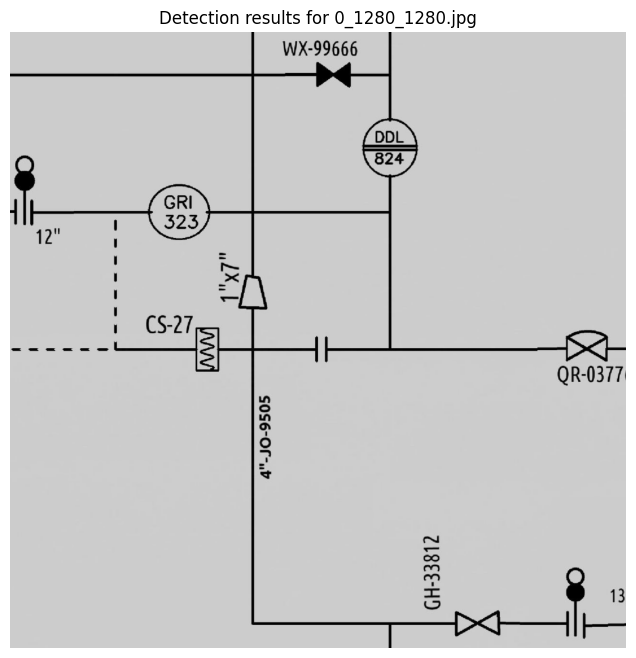


image 1/1 C:\Users\dell\pid_env\yolo_dataset\images\val\0_1280_1920.jpg: 640x640 1 gate_valve_vertical, 106.4ms
Speed: 4.0ms preprocess, 106.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)
Detections found for 0_1280_1920.jpg: 1 objects
 - Class: gate_valve_vertical, Confidence: 0.29
Saved annotated image to output_1.jpg


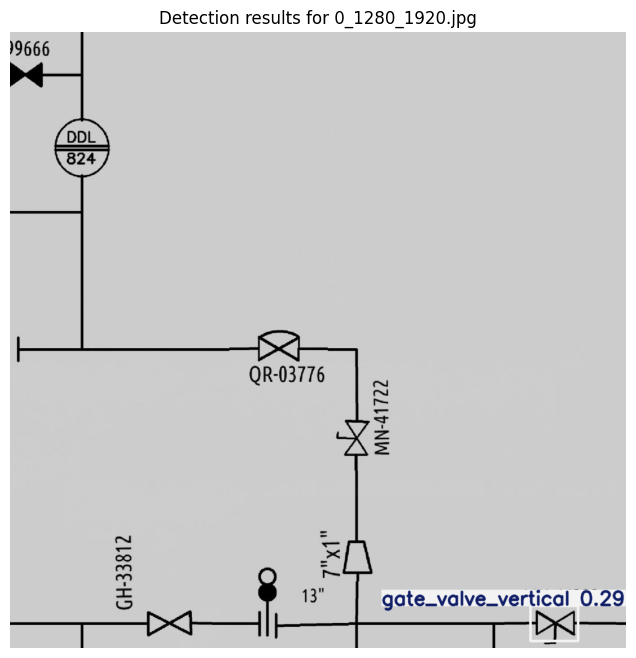


image 1/1 C:\Users\dell\pid_env\yolo_dataset\images\val\0_1920_1280.jpg: 640x640 (no detections), 103.9ms
Speed: 4.2ms preprocess, 103.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No detections found for 0_1920_1280.jpg with conf=0.25
Saved annotated image to output_2.jpg


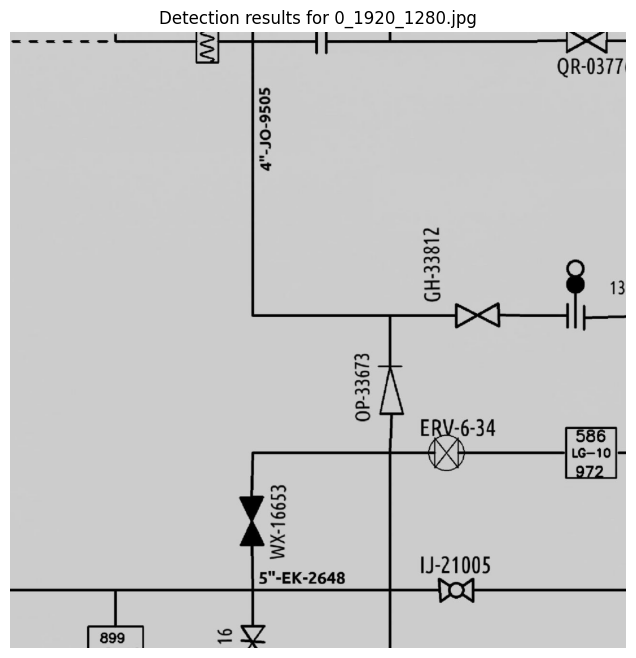

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained model
model_path = r'C:\Users\dell\runs\detect\pid_detector\weights\best.pt'
try:
    model = YOLO(model_path)
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Define paths
yolo_images_val = os.path.join('yolo_dataset', 'images', 'val')

print("Testing model on validation images...")
val_images = os.listdir(yolo_images_val)
test_results = []

if not val_images:
    print("No validation images found in", yolo_images_val)
else:
    for i, img_name in enumerate(val_images[:3]):  # Test on first 3 validation images
        test_image = os.path.join(yolo_images_val, img_name)
        
        # Verify image exists and is readable
        if not os.path.exists(test_image):
            print(f"Image not found: {test_image}")
            continue
        
        # Run inference with a lower confidence threshold
        results = model.predict(test_image, conf=0.25, verbose=True)
        
        # Check if detections were made
        if len(results[0].boxes) == 0:
            print(f"No detections found for {img_name} with conf=0.25")
        else:
            print(f"Detections found for {img_name}: {len(results[0].boxes)} objects")
            for box in results[0].boxes:
                class_id = int(box.cls)
                class_name = results[0].names[class_id]
                conf = float(box.conf)
                print(f" - Class: {class_name}, Confidence: {conf:.2f}")

        # Plot the results with bounding boxes and labels
        annotated_img = results[0].plot()  # Returns a BGR image with annotations
        
        # Convert BGR to RGB for Matplotlib
        annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        # Save the annotated image
        output_path = f'output_{i}.jpg'
        cv2.imwrite(output_path, annotated_img)
        print(f"Saved annotated image to {output_path}")
        
        # Display the image
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_img_rgb)
        plt.axis('off')
        plt.title(f"Detection results for {img_name}")
        plt.show()
        
        test_results.append((img_name, output_path))

# 14. Save the trained model

In [5]:
from ultralytics import YOLO


model = YOLO(r'C:\Users\dell\runs\detect\pid_detector\weights\best.pt')

model.save('pid_model.pt')
print("Model saved as 'pid_model.pt'")

Model saved as 'pid_model.pt'


# 15. Function to run inference on a custom image

In [ ]:
model = YOLO('pid_model.pt')
results = model.predict(r'C:\Users\dell\pid_env\pid_symbols_dataset\images\0_1280_1920.jpg', conf=0.25)
#in the above line you can paste your custom image and run and detect the images

Model loaded successfully from pid_model.pt

image 1/1 C:\Users\dell\pid_env\pid_symbols_dataset\images\0_1280_1920.jpg: 640x640 1 gate_valve_vertical, 107.0ms
Speed: 5.2ms preprocess, 107.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Inference completed for C:\Users\dell\pid_env\pid_symbols_dataset\images\0_1280_1920.jpg
Detected 1 symbols:
 - Class: gate_valve_vertical, Confidence: 0.29
Saved annotated image to custom_image_output.jpg


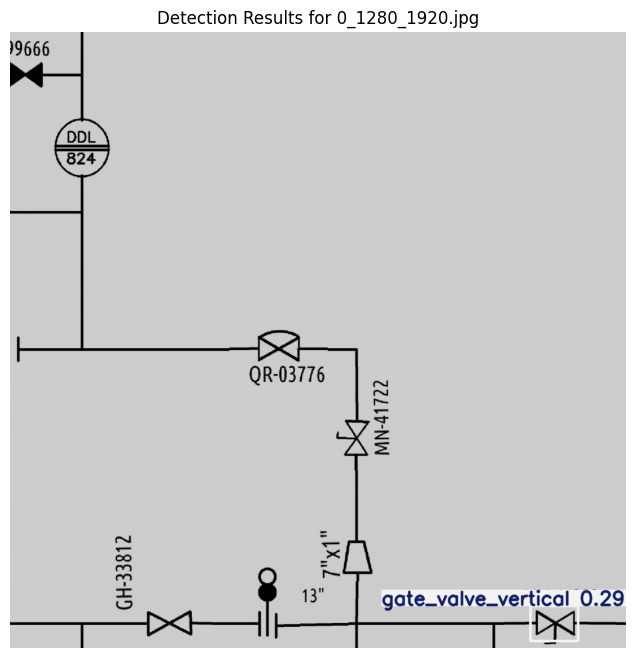

In [11]:
model_path = 'pid_model.pt'  # Path to your trained model
image_path = r'C:\Users\dell\pid_env\pid_symbols_dataset\images\0_1280_1920.jpg'  # Path to your custom image
output_path = 'custom_image_output.jpg'  # Path to save the annotated image


try:
    model = YOLO(model_path)
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Verify the image exists
if not os.path.exists(image_path):
    print(f"Image not found at: {image_path}")
    exit()

# Run inference on the custom image
try:
    results = model.predict(image_path, conf=0.25, verbose=True)
    print(f"Inference completed for {image_path}")
except Exception as e:
    print(f"Error during inference: {e}")
    exit()

# Check if detections were made
if len(results[0].boxes) == 0:
    print("No symbols detected in the image.")
else:
    print(f"Detected {len(results[0].boxes)} symbols:")
    for box in results[0].boxes:
        class_id = int(box.cls)
        class_name = results[0].names[class_id]
        conf = float(box.conf)
        print(f" - Class: {class_name}, Confidence: {conf:.2f}")

# Plot the results with bounding boxes and labels
annotated_img = results[0].plot()  # Returns a BGR image with annotations

# Convert BGR to RGB for Matplotlib
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

# Save the annotated image
try:
    cv2.imwrite(output_path, annotated_img)
    print(f"Saved annotated image to {output_path}")
except Exception as e:
    print(f"Error saving image: {e}")

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(annotated_img_rgb)
plt.axis('off')
plt.title(f"Detection Results for {os.path.basename(image_path)}")
plt.show()

# 16. Summary and instructions for using the model